In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import re
import gspread
import json
import os
import requests
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
file_data = json.load(open(os.path.expanduser("../../../ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

ruland_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1od248fJpNbwMO8IVZQVO3xnzrmmTe68yS9XWajyuk5o/edit?usp=sharing")

In [19]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [20]:
len(lexeme_df)

2846

In [21]:
lexeme_df.columns

Index(['Lemma', 'lemmas_all', 'target_canonical', 'entry_ids', 'entry_count',
       'types', 'variants', 'notes', 'senses_flat', 'sense_count',
       'sense_def_all', 'sense_def_strict_all', 'sense_raw_all',
       'translations_all', 'target_len', 'target_relemmatized',
       'instance_fname', 'noscemus_instances_N', 'cc_instances_N',
       'emlap_instances_N', 'emlap_instances', 'grela_instances_N'],
      dtype='object')

In [22]:
lexeme_df.loc[1780]

Lemma                                                       Machina, Axia
lemmas_all                                                [Machina, Axia]
target_canonical                                            machina, axia
entry_ids                                      [Ruland1612-Machina,-Axia]
entry_count                                                             1
types                                                                 [M]
variants                                                               []
notes                                                                  []
senses_flat             [{'def': 'axis stratus', 'entry_id': 'Ruland16...
sense_count                                                             1
sense_def_all                                              [axis stratus]
sense_def_strict_all                                       [axis stratus]
sense_raw_all                                    [, axis stratus. Welle.]
translations_all        [{'entry_id': 

In [23]:
emlap_metadata = pd.read_csv(
        "https://raw.githubusercontent.com/CCS-ZCU/EMLAP_ETL/refs/heads/master/data/emlap_metadata.csv",
        sep=";",
    )
emlap_metadata.head(5)

Unnamed: 0.1  Unnamed: 0                 working_title  \
0             0           0        Augurello, Chrysopoeia   
1             1           1         Pseudo-Lull, Secretis   
2             2           2  Pantheus, Ars Transmutatione   
3             3           3          Anon, Vera alchemiae   
4             4           4        Pantheus, Voarchadumia   

                                           filenames     no.  is_done  \
0       100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1  100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2  100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
3            100004_Anon1561_Verae_Alchemiae_MDZ_MBS  100004     True   
4               100005_Pantheus1530_Voarchadumia_ONB  100005     True   

   is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  ...  CONTENTS  \
0         True        713324.0         NaN           True  ...       NaN   
1        False             NaN         NaN           True  ...       NaN   
2        False             NaN         NaN           True  ...       NaN   
3        False             NaN         NaN           True  ...       NaN   
4        False             NaN         NaN           True  ...       NaN   

                     genre            subject SOURCE OF FILE  \
0            didactic poem            alchemy            NaN   
1                 treatise  alchemy, medicine            NaN   
2                 treatise            alchemy            NaN   
3  compendium, florilegium            alchemy            NaN   
4                 treatise            alchemy            NaN   

                                                link source_of_file  \
0       https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1  https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2  https://www.google.co.uk/books/edition/Ars_Tra...             GB   
3   https://mdz-nbn-resolving.de/details:bsb10141168            MDZ   
4                https://data.onb.ac.at/rep/10588E49            ONB   

  origin_of_copy  other_notes tokens_N  aurhor_wd  
0       Noscemus          NaN    23225        NaN  
1            MBS          NaN    24696        NaN  
2             BL          NaN     8683        NaN  
3            MBS          NaN   368660        NaN  
4            ONB          NaN    21175        NaN  

[5 rows x 57 columns]

In [24]:
emlap_metadata["tokens_N"].sum()

np.int64(6477016)

In [25]:
# to work excusively with works from the older period
#emlap_metadata = emlap_metadata[emlap_metadata["date_publication"]<=1600]

In [26]:
emlap_metadata.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'working_title', 'filenames', 'no.',
       'is_done', 'is_noscemus', 'if_noscemus_id', 'AUTHORSHIP',
       'is_one_author',
       '#if more than 1 author skip section and choose compendium below',
       'is_author_known', 'author_name', 'author_name_alternatives',
       'author_viaf', 'author_cerl', 'author_comments', 'is_compendium',
       'if_compendium', 'TRANSLATION / EDITORSHIP', 'is_translator',
       'translator_name', 'translator_name_alternatives',
       'translator_comments', 'is_editor', 'editor_name',
       'editor_name_alternatives', 'editor_comments', 'DATE OF PUBLICATION',
       'date_publication', 'date_certainty', 'date_not_after',
       'date_not_before', 'date_comment', 'TITLE', 'title_short', 'title_full',
       'title_viaf', 'title_comments', 'PLACE OF PUBLICATION',
       'place_publication', 'place_geonames', 'place_comments', 'PUBLISHER',
       'publisher_name', 'publisher_name_alternatives', 'publisher_comments'

In [27]:
emlap_metadata["labeldate"] = emlap_metadata.apply(lambda row: row["working_title"] + " ({})".format(str(row["date_publication"])), axis=1)

In [28]:
emlap_metadata.sort_values("date_publication", ascending=True, inplace=True)

## Exploring individual entries

In [31]:
# emlap_id_label_dict = dict(zip(emlap_metadata["No."], emlap_metadata["labeldate"]))

In [32]:
def extract_emlap_ids(emlap_instances):
    return [instance["grela_id"][6:] for instance in emlap_instances]

lexeme_df["instances_ids"] = lexeme_df["emlap_instances"].apply(extract_emlap_ids)

In [33]:
def make_plot_bar(entry):
    # Get instance IDs for the entry
    instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
    counter = Counter(instances_ids)

    # Extract the keys (labels) and their corresponding counts (frequencies)
    emlap_metadata_instances = emlap_metadata.copy()
    emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int)
    )

    # Add bidecade labels to the DataFrame
    def get_bidecade_label(year):
        if not np.isnan(year):  # Handle NaN years safely
            start = (year // 20) * 20  # Determine the starting year of the bidecade
            end = start + 19  # Determine the ending year of the bidecade
            return f"{start}-{end}"
        return None

    emlap_metadata_instances["Bidecade"] = emlap_metadata_instances["date_publication"].apply(get_bidecade_label)

    # Group by Bidecade and sum frequencies and tokens_N
    emlap_instances_grouped = (
        emlap_metadata_instances.groupby("Bidecade", dropna=True)[["Frequency", "tokens_N"]]
        .sum()
        .reset_index()
    )

    # Sort bidecade intervals numerically
    emlap_instances_grouped = emlap_instances_grouped.sort_values(
        by="Bidecade",
        key=lambda col: col.str.extract(r"(\d+)")[0].astype(int)
    )

    # Calculate relative frequency (Frequency / tokens_N)
    emlap_instances_grouped["RelativeFrequency"] = (
        emlap_instances_grouped["Frequency"] / emlap_instances_grouped["tokens_N"]
    )

    # Calculate relative frequency for individual works
    emlap_metadata_instances["RelativeFrequency"] = (
        emlap_metadata_instances["Frequency"] / emlap_metadata_instances["tokens_N"]
    )

    # Create the 4 subplots (2x2 layout)
    fig, axes = plt.subplots(2, 2, figsize=(30, 12), dpi=300)

    # Plot 1: Absolute frequency vs. bidecades
    ax1 = axes[0, 0]
    ax1.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["Frequency"],
        color="blue"
    )
    ax1.set_xlabel("Bidecades", fontsize=12)
    ax1.set_ylabel("Absolute Frequency", fontsize=12)
    ax1.set_title(f"Absolute Frequency of '{entry}' by Bidecades", fontsize=14)
    ax1.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax1.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 2: Relative frequency vs. bidecades
    ax2 = axes[0, 1]
    ax2.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["RelativeFrequency"],
        color="orange"
    )
    ax2.set_xlabel("Bidecades", fontsize=12)
    ax2.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax2.set_title(f"Relative Frequency of '{entry}' by Bidecades", fontsize=14)
    ax2.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax2.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 3: Absolute frequency vs. works
    ax3 = axes[1, 0]
    ax3.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["Frequency"],
        color="blue"
    )
    ax3.set_xlabel("Works", fontsize=12)
    ax3.set_ylabel("Absolute Frequency", fontsize=12)
    ax3.set_title(f"Absolute Frequency of '{entry}' by Works", fontsize=14)
    ax3.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax3.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90, fontsize=9)

    # Plot 4: Relative frequency vs. works
    ax4 = axes[1, 1]
    ax4.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["RelativeFrequency"],
        color="orange"
    )
    ax4.set_xlabel("Works", fontsize=12)
    ax4.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax4.set_title(f"Relative Frequency of '{entry}' by Works", fontsize=14)
    ax4.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax4.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90, fontsize=9)

    # Adjust layout and display the plots
    plt.tight_layout()
    #plt.show()
    return fig

In [19]:
entry = "Lapis philosophorum"
instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
counter = Counter(instances_ids)
emlap_metadata_instances = emlap_metadata.copy()
emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int))

In [20]:
emlap_metadata_instances.head(5)

Unnamed: 0.1  Unnamed: 0                    working_title  \
0              0           0           Augurello, Chrysopoeia   
1              1           1            Pseudo-Lull, Secretis   
2              2           2     Pantheus, Ars Transmutatione   
8              8           8  Vegius, Inter inferiora corpora   
12            12          12                  Ulstadt, Coelum   

                                            filenames     no.  is_done  \
0        100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1   100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2   100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
8   100009_Vegius1518_Inter_inferiora_corpora_disp...  100009     True   
12  100013_Ulstad1525_Coelum_philosophorum_Medica_...  100013     True   

    is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  ...  \
0          True        713324.0         NaN           True  ...   
1         False             NaN         NaN           True  ...   
2         False             NaN         NaN           True  ...   
8         False             NaN         NaN          False  ...   
12        False             NaN         NaN           True  ...   

                   subject  SOURCE OF FILE  \
0                  alchemy             NaN   
1        alchemy, medicine             NaN   
2                  alchemy             NaN   
8   Renaissance philosophy             NaN   
12   alchemy, quintessence             NaN   

                                                 link source_of_file  \
0        https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1   https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2   https://www.google.co.uk/books/edition/Ars_Tra...             GB   
8                  http://data.onb.ac.at/rep/1099703B            ONB   
12  https://www.biusante.parisdescartes.fr/histmed...         Medica   

   origin_of_copy other_notes tokens_N  aurhor_wd  \
0        Noscemus         NaN    23225        NaN   
1             MBS         NaN    24696        NaN   
2              BL         NaN     8683        NaN   
8             ONB         NaN    27814        NaN   
12          BIUSP         NaN    41603  Q18026923   

                                 labeldate  Frequency  
0            Augurello, Chrysopoeia (1515)          0  
1             Pseudo-Lull, Secretis (1518)          4  
2      Pantheus, Ars Transmutatione (1518)          0  
8   Vegius, Inter inferiora corpora (1518)          0  
12                  Ulstadt, Coelum (1525)          7  

[5 rows x 59 columns]

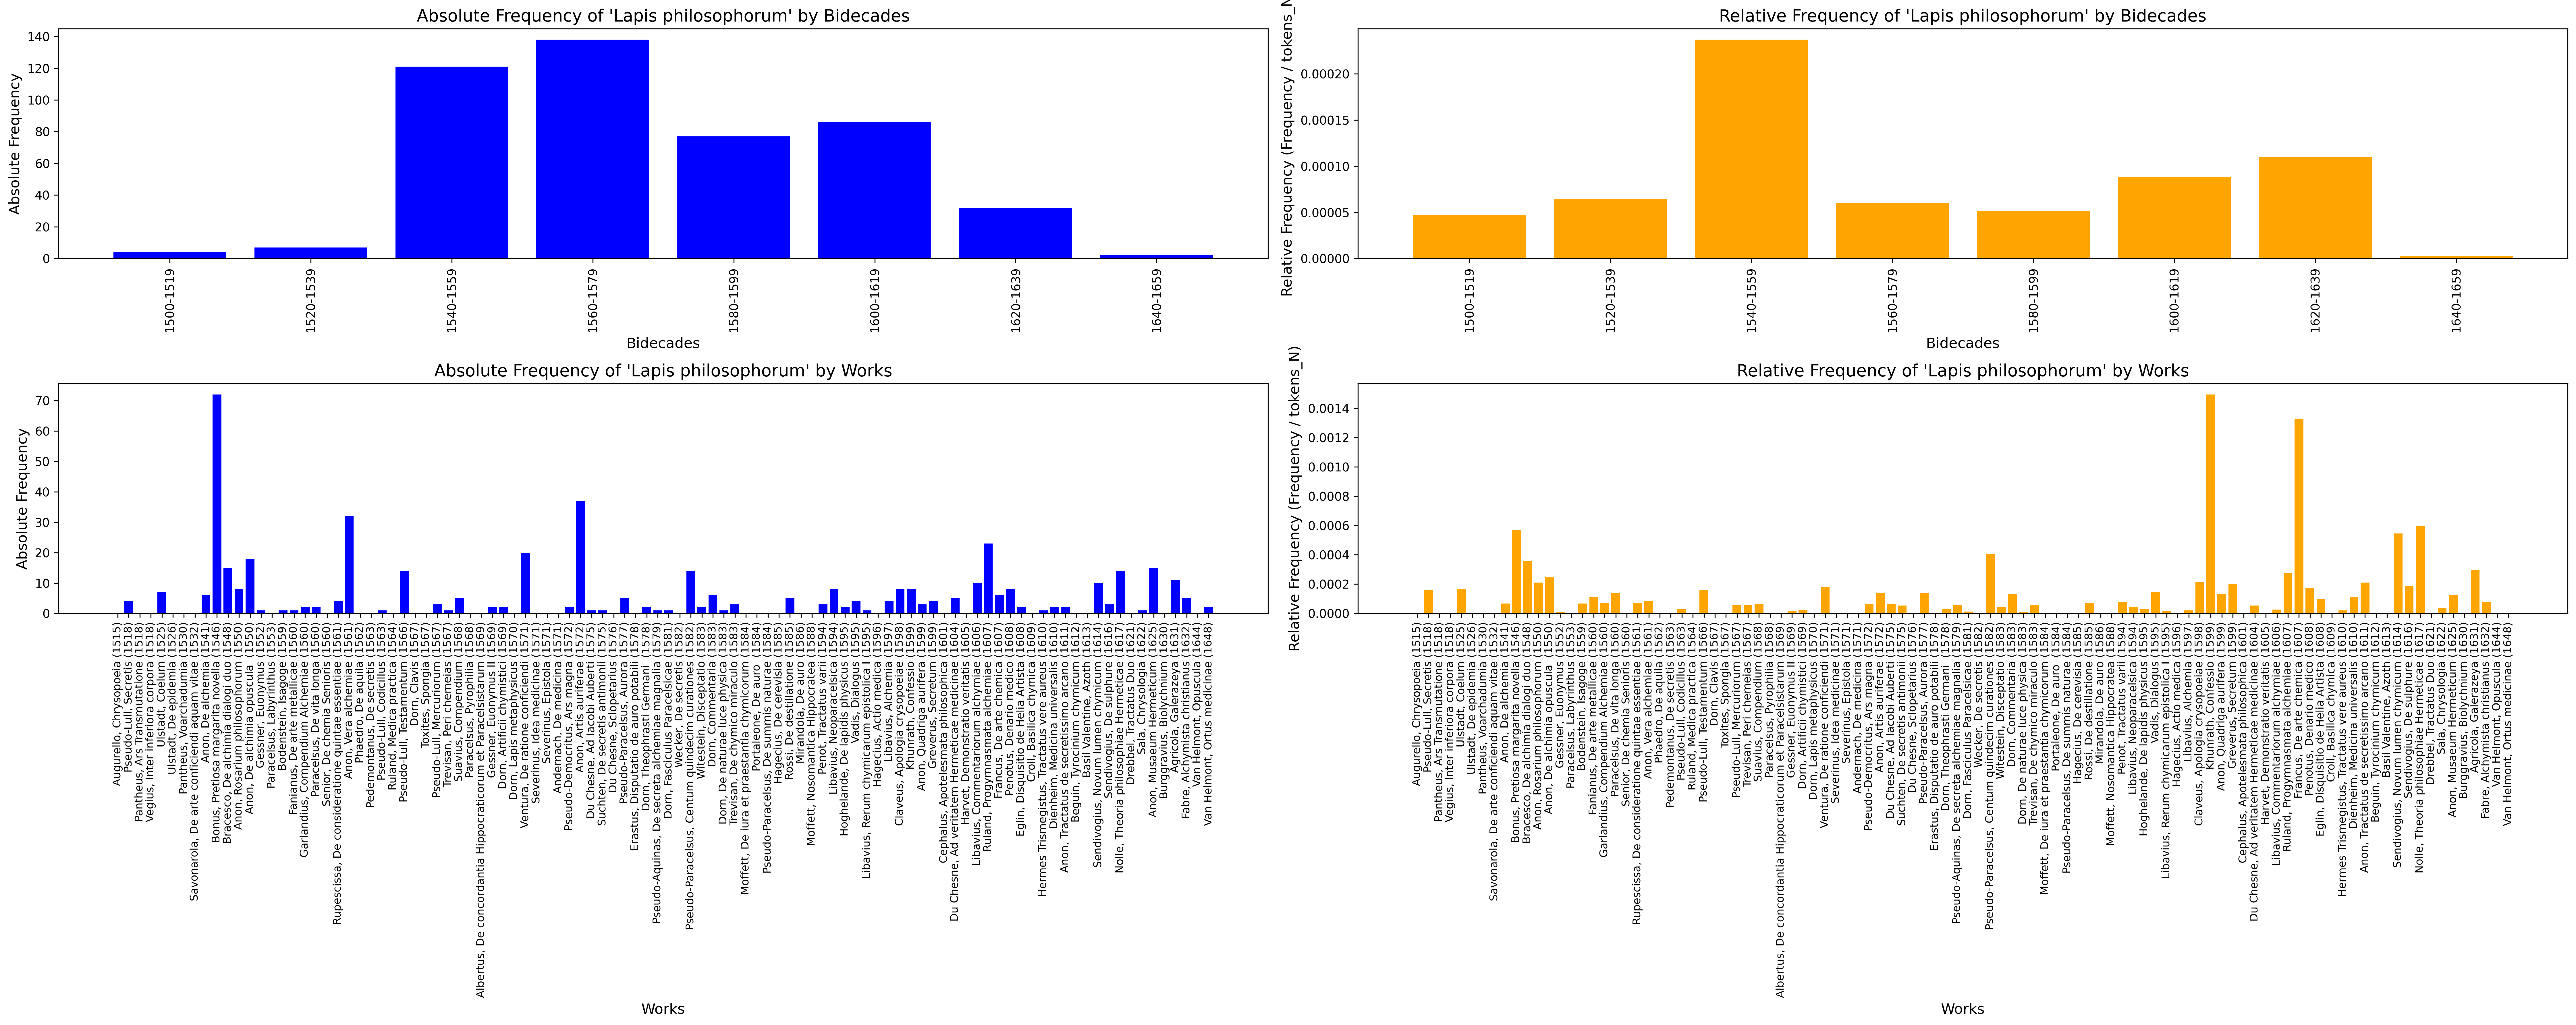

In [38]:
entry = "Lapis philosophorum"
fig = make_plot_bar(entry)

In [50]:
fig.savefig("../figures/casestudy_lapis_philosophorum.png", dpi=300)

## Overview

In [48]:
api_url = "https://ccs-lab.zcu.cz/grela-api/api/query"
query = "SELECT * FROM works"
works_df = pd.read_parquet(requests.post(api_url, json={"query": query}).json()["download_url"])

In [88]:
import json
import pandas as pd

def to_dict(x):
    if pd.isna(x):
        return {}
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)   # -> dict
        except json.JSONDecodeError:
            return {}
    return {}

works_df["noscemus_discipline"] = (
    works_df["subcorpus_specific_metadata"]
      .map(to_dict)
      .map(lambda d: d.get("noscemus_discipline"))
)

In [91]:
works_df[works_df["noscemus_discipline"].str.contains("Alchem", na=False)]

grela_source          grela_id                       author  \
9979      noscemus   noscemus_705665            Achrelius, Daniel   
9991      noscemus   noscemus_658534              Agricola, Georg   
10005     noscemus   noscemus_863735                  Anonymus 12   
10025     noscemus   noscemus_713324  Augurello, Giovanni Aurelio   
10029     noscemus  noscemus_1031760               Bacon, Francis   
...            ...               ...                          ...   
10870     noscemus   noscemus_695644           Stattler, Benedikt   
10871     noscemus   noscemus_695645           Stattler, Benedikt   
10878     noscemus   noscemus_668494         Stromeyer, Friedrich   
10887     noscemus   noscemus_604892            Tazewell, William   
10933     noscemus   noscemus_801656        Wedel, Georg Wolfgang   

                                                   title  not_before  \
9979   Scientiarum magnes recitatus publice anno 1690...        1690   
9991   De re metallica libri XII, quibus officia, ins...        1556   
10005  XVII. Discorso dei vantaggi della educazione f...        1785   
10025                                               None        1515   
10029  Pars secunda operis, quae dicitur Novum Organu...        1620   
...                                                  ...         ...   
10870  Mineralogiae et metallurgiae chemicae principi...        1765   
10871  Mineralogiae et metallurgiae chemicae principi...        1765   
10878  De gas hydrogenii arseniati natura atque indol...        1808   
10887  Vade-mecum medicum in duas partes divisum, qua...        1798   
10933  Georgii Wolffgangi Wedelii doctoris, medici du...        1671   

       not_after  date_random provenience place_publication place_geonames  \
9979        1690         1690        None              None           None   
9991        1556         1556        None              None           None   
10005       1785         1785        None              None           None   
10025       1515         1515        None              None           None   
10029       1620         1620        None              None           None   
...          ...          ...         ...               ...            ...   
10870       1765         1765        None              None           None   
10871       1765         1765        None              None           None   
10878       1808         1808        None              None           None   
10887       1798         1798        None              None           None   
10933       1671         1671        None              None           None   

      author_viaf author_wd  author_gnd title_viaf  \
9979     44659002  Q5541951  1055219730       None   
9991         None      None   118501062       None   
10005        None      None        None       None   
10025        None      None        None       None   
10029        None      None   118505696       None   
...           ...       ...         ...        ...   
10870        None      None   118752839       None   
10871        None      None   118752839       None   
10878        None      None   117345822       None   
10887        None      None        None       None   
10933        None      None   104045396       None   

                             subcorpus_specific_metadata  token_count  \
9979   {"lagt_tlg_epithet":null,"lagt_genre":null,"no...         8839   
9991   {"lagt_tlg_epithet":null,"lagt_genre":null,"no...       221485   
10005  {"lagt_tlg_epithet":null,"lagt_genre":null,"no...        49482   
10025  {"lagt_tlg_epithet":null,"lagt_genre":null,"no...            0   
10029  {"lagt_tlg_epithet":null,"lagt_genre":null,"no...            0   
...                                                  ...          ...   
10870  {"lagt_tlg_epithet":null,"lagt_genre":null,"no...        47806   
10871  {"lagt_tlg_epithet":null,"lagt_genre":null,"no...            0   
10878  {"lagt_tlg_epithet":null,"lagt_genre":null,"no...        34164

In [51]:
works_df.groupby("grela_source").sum()["token_count"]

grela_source
cc          254770887
emlap         6477016
lagt         38223149
noscemus     54542448
vulgate        603091
Name: token_count, dtype: int64

In [53]:
corpora_token_counts_dict = works_df.groupby("grela_source").sum()["token_count"].to_dict()
corpora_token_counts_dict

{'cc': 254770887,
 'emlap': 6477016,
 'lagt': 38223149,
 'noscemus': 54542448,
 'vulgate': 603091}

In [92]:
corpora_token_counts_dict['grela'] = sum([corpora_token_counts_dict["cc"], corpora_token_counts_dict["noscemus"], corpora_token_counts_dict["emlap"]])

In [93]:
(corpora_token_counts_dict["emlap"] / corpora_token_counts_dict["cc"]) / 1

0.02542290477640014

In [94]:
1 / 0.025

40.0

In [95]:
corpora_token_counts_dict["emlap"] / corpora_token_counts_dict["noscemus"]


0.11875183893469542

In [96]:
1 / 0.119

8.403361344537815

In [13]:
lexeme_df["target_len"].value_counts()

target_len
1    1799
2     853
3     194
Name: count, dtype: int64

In [42]:
sum(lexeme_df["grela_instances_N"]>0)

2770

In [43]:
sum(lexeme_df["grela_instances_N"]>0) / len(lexeme_df)


0.9732958538299368

In [44]:
sum(lexeme_df["emlap_instances_N"]>0)

1457

In [45]:
lexeme_df["grela_instances_N"].sum()

np.int64(3419737)

In [46]:
lexeme_df["emlap_instances_N"].sum()

np.int64(288785)

In [15]:
lexeme_df.sort_values("emlap_instances_N", ascending=False)[:10]

Lemma   lemmas_all target_canonical  \
596       Aurum      [Aurum]            aurum   
526    Argentum   [Argentum]         argentum   
29        Oleum      [Oleum]            oleum   
2277        Sal        [Sal]              sal   
96     Metallum   [Metallum]         metallum   
27    Mercurius  [Mercurius]        mercurius   
10      Sulphur    [Sulphur]          sulphur   
1200  Elementum  [Elementum]        elementum   
18     Essentia   [Essentia]         essentia   
197         Aer        [Aer]              aer   

                                              entry_ids  entry_count types  \
596                                  [Ruland1612-Aurum]            1   [A]   
526   [Ruland1612-Argentum-à-Chymistis-Luna,-cui-eti...            1   [A]   
29    [Ruland1612-Oleum, Ruland1612-Oleum, Ruland161...            3   [O]   
2277                                   [Ruland1612-Sal]            1   [S]   
96           [Ruland1612-Metallum, Ruland1612-Metallum]            2   [M]   
27    [Ruland1612-Mercurius, Ruland1612-Mercurius, R...            3   [M]   
10    [Ruland1612-Sulphur, Ruland1612-Sulphur, Rulan...            4   [S]   
1200                             [Ruland1612-Elementum]            1   [E]   
18    [Ruland1612-Essentia, Ruland1612-Essentia, Rul...            3   [E]   
197                                    [Ruland1612-Aer]            1   [A]   

        variants                                              notes  \
596           []  [Natiuum purum, quod a natura tale est, cuius ...   
526   [Argentum]                                                 []   
29            []                                                 []   
2277          []                                                 []   
96            []                                                 []   
27            []                                                 []   
10            []                                                 []   
1200          []                                                 []   
18            []                                                 []   
197           []                                                 []   

                                            senses_flat  sense_count  ...  \
596   [{'def': 'à Germanis', 'entry_id': 'Ruland1612...            1  ...   
526   [{'def': 'à Chymistis Luna, cui etiam tribuitu...            1  ...   
29    [{'def': 'id est, ignis, wirdt außgezogen von ...            3  ...   
2277  [{'def': 'Alas Graece, Melech Arabice, vel sel...            1  ...   
96    [{'def': 'vena, Ertz.', 'entry_id': 'Ruland161...            2  ...   
27    [{'def': 'id est, sulphur.', 'entry_id': 'Rula...            3  ...   
10    [{'def': 'chibur, vel, Albusao Arabice dicitur...            4  ...   
1200  [{'def': 'quicquid ex matricibus elementorum p...            1  ...   
18    [{'def': 'est extractum simplex e reb. tota su...            3  ...   
197   [{'def': 'id est, aura, halitus, spiritus, ven...            1  ...   

                                   sense_def_strict_all  \
596                                        [à Germanis]   
526             [à Chymistis Luna, cui etiam tribuitur]   
29    [id est, ignis, wirdt außgezogen von einer tro...   
2277  [Alas Graece, Melech Arabice, vel selenipum es...   
96           [vena, Ertz., id est, conflatum argentum.]   
27    [id est, sulphur., est principium materiale, v...   
10    [chibur, vel, Albusao Arabice dicitur, pars la...   
1200     [quicquid ex matricibus elementorum prouenit,]   
18    [est extractum simplex e reb. tota sua natura ...   
197          [id est, aura, halitus, spiritus, ventus,]   

                                          sense_raw_all  \
596   [, à Germanis Goldtsa Chymistis dicitur Sol, &...   
526   [à Chymistis Luna, cui etiam tribuitur: estque...   
29    [id est, ignis, wirdt außgezogen von einer tro...   
2277  [Alas Graece, Melech Arabice, vel selenipum es...   
96           [vena, Ertz., id est, c

In [37]:
lexeme_df.columns

Index(['Lemma', 'lemmas_all', 'target_canonical', 'entry_ids', 'entry_count',
       'types', 'variants', 'notes', 'senses_flat', 'sense_count',
       'sense_def_all', 'sense_def_strict_all', 'sense_raw_all',
       'translations_all', 'target_len', 'target_relemmatized',
       'instance_fname', 'noscemus_instances_N', 'cc_instances_N',
       'emlap_instances_N', 'emlap_instances', 'grela_instances_N',
       'instances_ids'],
      dtype='object')

In [108]:
lexeme_df.head(5)

Lemma        lemmas_all target_canonical  \
0   Naphtha         [Naphtha]          naphtha   
1    Baurac  [Baurac, Bäurac]           baurac   
2    Nitrum          [Nitrum]           nitrum   
3    Elixir          [Elixir]           elixir   
4  Magnesia        [Magnesia]         magnesia   

                                           entry_ids  entry_count types  \
0                               [Ruland1612-Naphtha]            1   [N]   
1  [Ruland1612-Baurac, Ruland1612-Baurac, Ruland1...           10   [B]   
2  [None, Ruland1612-Nitrum, Ruland1612-Nitrum, R...            9   [N]   
3  [Ruland1612-Elixir,-Elei,, Ruland1612-Elixir, ...            6   [E]   
4  [Ruland1612-Magnesia, Ruland1612-Magnesia, Rul...            5   [M]   

      variants notes                                        senses_flat  \
0           []    []  [{'def': 'id est, pir, ignis.; id est, flatus ...   
1           []    []  [{'def': None, 'entry_id': 'Ruland1612-Baurac'...   
2           []    []  [{'def': 'Baurach, sal petrosum, nitrum à Germ...   
3  [Elei, Xir]    []  [{'def': 'id est, Medicina.', 'entry_id': 'Rul...   
4           []    []  [{'def': 'id est, testudo vel sulphul.', 'entr...   

   sense_count  ... noscemus_instances_N cc_instances_N emlap_instances_N  \
0           15  ...                  243             48                20   
1           10  ...                   35              0                 2   
2            9  ...                 3205           1371               728   
3            5  ...                  599             74              1455   
4            5  ...                  253            131               326   

                                     emlap_instances  grela_instances_N  \
0  [{'author': 'Gessner, Conrad', 'end_sentence_i...                311   
1  [{'author': 'Gratarolo, Guilelmo', 'end_senten...                 37   
2  [{'author': 'Augurelli, Giovanni Aurelio', 'en...               5304   
3  [{'author': 'Augurelli, Giovanni Aurelio', 'en...               2128   
4  [{'author': 'Panteo, Giovanni Agostino', 'end_...                710   

                                       instances_ids emlap_rel_freq  \
0  [100012, 100012, 100012, 100038, 100063, 10007...       0.000003   
1                                   [100004, 100004]       0.000000   
2  [100001, 100002, 100002, 100004, 100004, 10000...       0.000112   
3  [100001, 100004, 100004, 100004, 100004, 10000...       0.000225   
4  [100003, 100003, 100003, 100003, 100004, 10000...       0.000050   

   noscemus_rel_freq  cc_rel_freq  grela_rel_freq  
0           0.000004     0.000000        0.000001  
1           0.000001     0.000000        0.000000  
2           0.000059     0.000005        0.000017  
3           0.000011     0.000000        0.000007  
4           0.000005     0.000001        0.000002  

[5 rows x 27 columns]

In [106]:
top_10_emlap_instances_N = lexeme_df[['Lemma', 'target_canonical', 'target_relemmatized', 'emlap_instances_N', 'noscemus_instances_N', 'cc_instances_N','grela_instances_N']].sort_values("emlap_instances_N", ascending=False)[:10]

In [ ]:
set_with_dataframe(ruland_gs.add_worksheet("ruland_top10_2025-12-17", 1,1), top_10_emlap_instances_N)

In [ ]:
top_10_emlap_instances_N.to_csv("../data/lexeme_df_instances.csv")

In [118]:
# calculate relative frequency across corpora
for corp_label in ["emlap", "noscemus", "cc", "grela"]:
    corpus_token_count = corpora_token_counts_dict[corp_label]
    lexeme_df[f"{corp_label}_rel_freq"] = lexeme_df[f"{corp_label}_instances_N"] / corpus_token_count

In [120]:
# calculate relative frequency of terms weighted by their overall frequency in Latin part of Grela
lexeme_df["emlap_vs_grela_rel_freq"] = lexeme_df["emlap_rel_freq"] / lexeme_df["grela_rel_freq"]

In [124]:
top_20_emlap_vs_grela_rel_freq = lexeme_df[['Lemma', 'target_canonical', 'target_relemmatized', 'emlap_vs_grela_rel_freq', 'emlap_instances_N', 'noscemus_instances_N', 'cc_instances_N','grela_instances_N']].sort_values("emlap_vs_grela_rel_freq", ascending=False)[:20]
top_20_emlap_vs_grela_rel_freq

Lemma   target_canonical target_relemmatized  \
762    Calcinatum maius   calcinatum maius   calcinatus magnus   
2476           Spagirus           spagirus            spagirus   
2475           Spagiria           spagiria            spagiria   
2829        Aeruginatio        aeruginatio         aeruginatio   
509             Archeus            archeus             archeus   
1583          Inhumatio          inhumatio           inhumatio   
46       Balneum Mariae     balneum mariae       balneum maria   
1169            Duelech            duelech             duelech   
2635             Thucia             thucia              thucia   
177               Adech              adech               adech   
890          Cementatio         cementatio          cementatio   
2024        Oppodeltoch        oppodeltoch         oppodeltoch   
487   Aqua philosophica  aqua philosophica  aqua philosophicus   
959          Citrinatio         citrinatio          citrinatio   
1568          Inceratio          inceratio           inceratio   
1001         Coloritium         coloritium          coloritium   
59          Diuaporatio        diuaporatio         diuaporatio   
1395     Furnus acediae     furnus acediae       furnus acedia   
259               Albot              albot               albot   
1240    Essentia quinta    essentia quinta    essentia quintus   

      emlap_vs_grela_rel_freq  emlap_instances_N  noscemus_instances_N  \
762                 48.755530                  5                     0   
2476                46.588618                 43                     2   
2475                46.317754                 95                     5   
2829                46.189450                 18                     1   
509                 45.797934               1022                    64   
1583                45.652906                103                     6   
46                  45.179330                379                    24   
1169                44.582760                203                    19   
2635                44.323210                 20                     2   
177                 44.112147                 19                     2   
890                 44.112147                 57                     6   
2024                44.037253                 28                     3   
487                 43.754963                 35                     4   
959                 43.653208                 77                     7   
1568                43.568772                168                    20   
1001                43.215129                 39                     5   
59                  43.019586                 45                     5   
1395                42.661089                  7                     1   
259                 42.464494                 27                     3   
1240                42.153219                249                    37   

      cc_instances_N  grela_instances_N  
762                0                  5  
2476               0                 45  
2475               0                100  
2829               0                 19  
509                2               1088  
1583               1                110  
46                 6                409  
1169               0                222  
2635               0                 22  
177                0                 21  
890                0                 63  
2024               0                 31  
487                0                 39  
959                2                 86  
1568               0                188  
1001               0                 44  
59                 1                 51  
1395               0                  8  
259                1                 31  
1240               2                288

In [125]:
set_with_dataframe(ruland_gs.add_worksheet("ruland_top20_emlap_vs_grela_rel_freq_2025-12-17", 1,1), top_20_emlap_vs_grela_rel_freq)

In [126]:
# explore multiword entries specifically

lexeme_df[lexeme_df["target_len"]>1].sort_values("emlap_instances_N", ascending=False)[:10]

Lemma             lemmas_all     target_canonical  \
33        Quinta essentia      [Quinta essentia]      quinta essentia   
494            Aqua vitae           [Aqua vitae]           aqua uitae   
478           Aqua fortis          [Aqua fortis]          aqua fortis   
2285       Sal armoniacus       [Sal armoniacus]       sal armoniacus   
1698  Lapis philosophorum  [Lapis philosophorum]  lapis philosophorum   
602        Aurum potabile       [Aurum potabile]       aurum potabile   
46         Balneum Mariae       [Balneum Mariae]       balneum mariae   
1845        Materia prima        [Materia prima]        materia prima   
789       Calor naturalis      [Calor naturalis]      calor naturalis   
2307           Sal petrae           [Sal petrae]           sal petrae   

                                              entry_ids  entry_count types  \
33    [Ruland1612-Quinta-essentia, Ruland1612-Quinta...            3   [Q]   
494                             [Ruland1612-Aqua-vitae]            1   [A]   
478                            [Ruland1612-Aqua-fortis]            1   [A]   
2285                        [Ruland1612-Sal-armoniacus]            1   [S]   
1698                   [Ruland1612-Lapis-philosophorum]            1   [L]   
602                         [Ruland1612-Aurum-potabile]            1   [A]   
46    [Ruland1612-Balneum-Mariae, Ruland1612-Balneum...            2   [B]   
1845                         [Ruland1612-Materia-prima]            1   [M]   
789                        [Ruland1612-Calor-naturalis]            1   [C]   
2307                            [Ruland1612-Sal-petrae]            1   [S]   

     variants notes                                        senses_flat  \
33         []    []  [{'def': 'est natura vires, virtus color vita,...   
494        []    []  [{'def': 'id est, Mercurius', 'entry_id': 'Rul...   
478        []    []  [{'def': 'est, quae ex auibus, & corrosiuis ce...   
2285       []    []  [{'def': 'id est, sal saparicius, vel defossum...   
1698       []    []  [{'def': 'sein die Haar der Menschen.', 'entry...   
602        []    []  [{'def': 'est liquor, sine corrosiuo, quod pau...   
46         []    []  [{'def': 'id est, aqua calida.', 'entry_id': '...   
1845       []    []  [{'def': '& huius vocabula,', 'entry_id': 'Rul...   
789        []    []  [{'def': 'est, quando radii solares, vel per s...   
2307       []    []  [{'def': 'est, quod in testudinibus cellarum n...   

      sense_count  ... cc_instances_N emlap_instances_N  \
33              3  ...             86              1781   
494             1  ...            195               922   
478             1  ...             62               684   
2285            1  ...              9               483   
1698            1  ...              0               467   
602             1  ...              5               405   
46              2  ...              6               379   
1845            1  ...           1875               357   
789             1  ...            871               301   
2307            1  ...             10               291   

                                        emlap_instances grela_instances_N  \
33    [{'author': 'Pseudo-Lull', 'end_sentence_id': ...              2383   
494   [{'author': 'Panteo, Giovanni Agostino', 'end_...              1311   
478   [{'author': 'Pseudo-Lull', 'end_sentence_id': ...              1054   
2285  [{'author': 'Pseudo-Lull', 'end_sentence_id': ...               695   
1698  [{'author': 'Pseudo-Lull', 'end_sentence_id': ...               603   
602   [{'author': 'Gratarolo, Guilelmo', 'end_senten...               482   
46    [{'author': 'Gratarolo, Guilelmo', 'end_senten...               409   
1845  [{'author': 'Pseudo-Lull', 'end_sentence_id': ...              2495   
789   [{'author': 'Panteo, Giovanni Agostino', 'end_...              1447   
2307  [{'author': 'Gratarolo, Guilelmo', 'end_senten...               381   

                                          in

## Distributions of EMLAP works

In [127]:
lexeme_df["instances_counter"] = lexeme_df["instances_ids"].apply(Counter)

In [128]:
lexeme_df["instances_counter"].tolist()[:10]

[Counter({'100085': 14, '100012': 3, '100038': 1, '100063': 1, '100070': 1}),
 Counter({'100004': 2}),
 Counter({'100070': 102,
          '100034': 99,
          '100004': 46,
          '100072': 41,
          '100015': 39,
          '100075': 36,
          '100085': 36,
          '100044': 35,
          '100067': 34,
          '100076': 21,
          '100091': 18,
          '100032': 15,
          '100084': 14,
          '100038': 12,
          '100093': 12,
          '100012': 10,
          '100030': 9,
          '100069': 9,
          '100087': 9,
          '100081': 8,
          '100100': 8,
          '100005': 7,
          '100039': 7,
          '100043': 7,
          '100046': 7,
          '100011': 6,
          '100026': 6,
          '100049': 6,
          '100028': 5,
          '100097': 5,
          '100010': 4,
          '100013': 4,
          '100020': 4,
          '100016': 3,
          '100027': 3,
          '100073': 3,
          '100079': 3,
          '100098': 3,
      

In [129]:
distribution = sum(lexeme_df["instances_counter"], Counter())

In [130]:
distribution

Counter({'100004': 21381,
         '100085': 19893,
         '100070': 18155,
         '100072': 15367,
         '100100': 13915,
         '100038': 13671,
         '100067': 9225,
         '100032': 7573,
         '100015': 6759,
         '100075': 6751,
         '100016': 6731,
         '100097': 5953,
         '100065': 5278,
         '100012': 5242,
         '100011': 5187,
         '100028': 5075,
         '100084': 4514,
         '100022': 4447,
         '100074': 4443,
         '100044': 4186,
         '100094': 4075,
         '100071': 3783,
         '100069': 3330,
         '100091': 3163,
         '100059': 3129,
         '100010': 3123,
         '100076': 3061,
         '100049': 2924,
         '100030': 2680,
         '100063': 2569,
         '100013': 2451,
         '100040': 2402,
         '100045': 2402,
         '100007': 2290,
         '100087': 2241,
         '100034': 2240,
         '100064': 2238,
         '100046': 2211,
         '100020': 2130,
         '100056': 

In [160]:
df = emlap_metadata.copy()
df["Frequency"] = (
        df["no."].astype(str).map(distribution).fillna(0).astype(int)
    )
df["RelativeFrequency"] = df["Frequency"] / df["tokens_N"]

    # Sort by publication date for a chronological x-axis
# df = df.sort_values(["date_publication", "labeldate"], na_position="last")



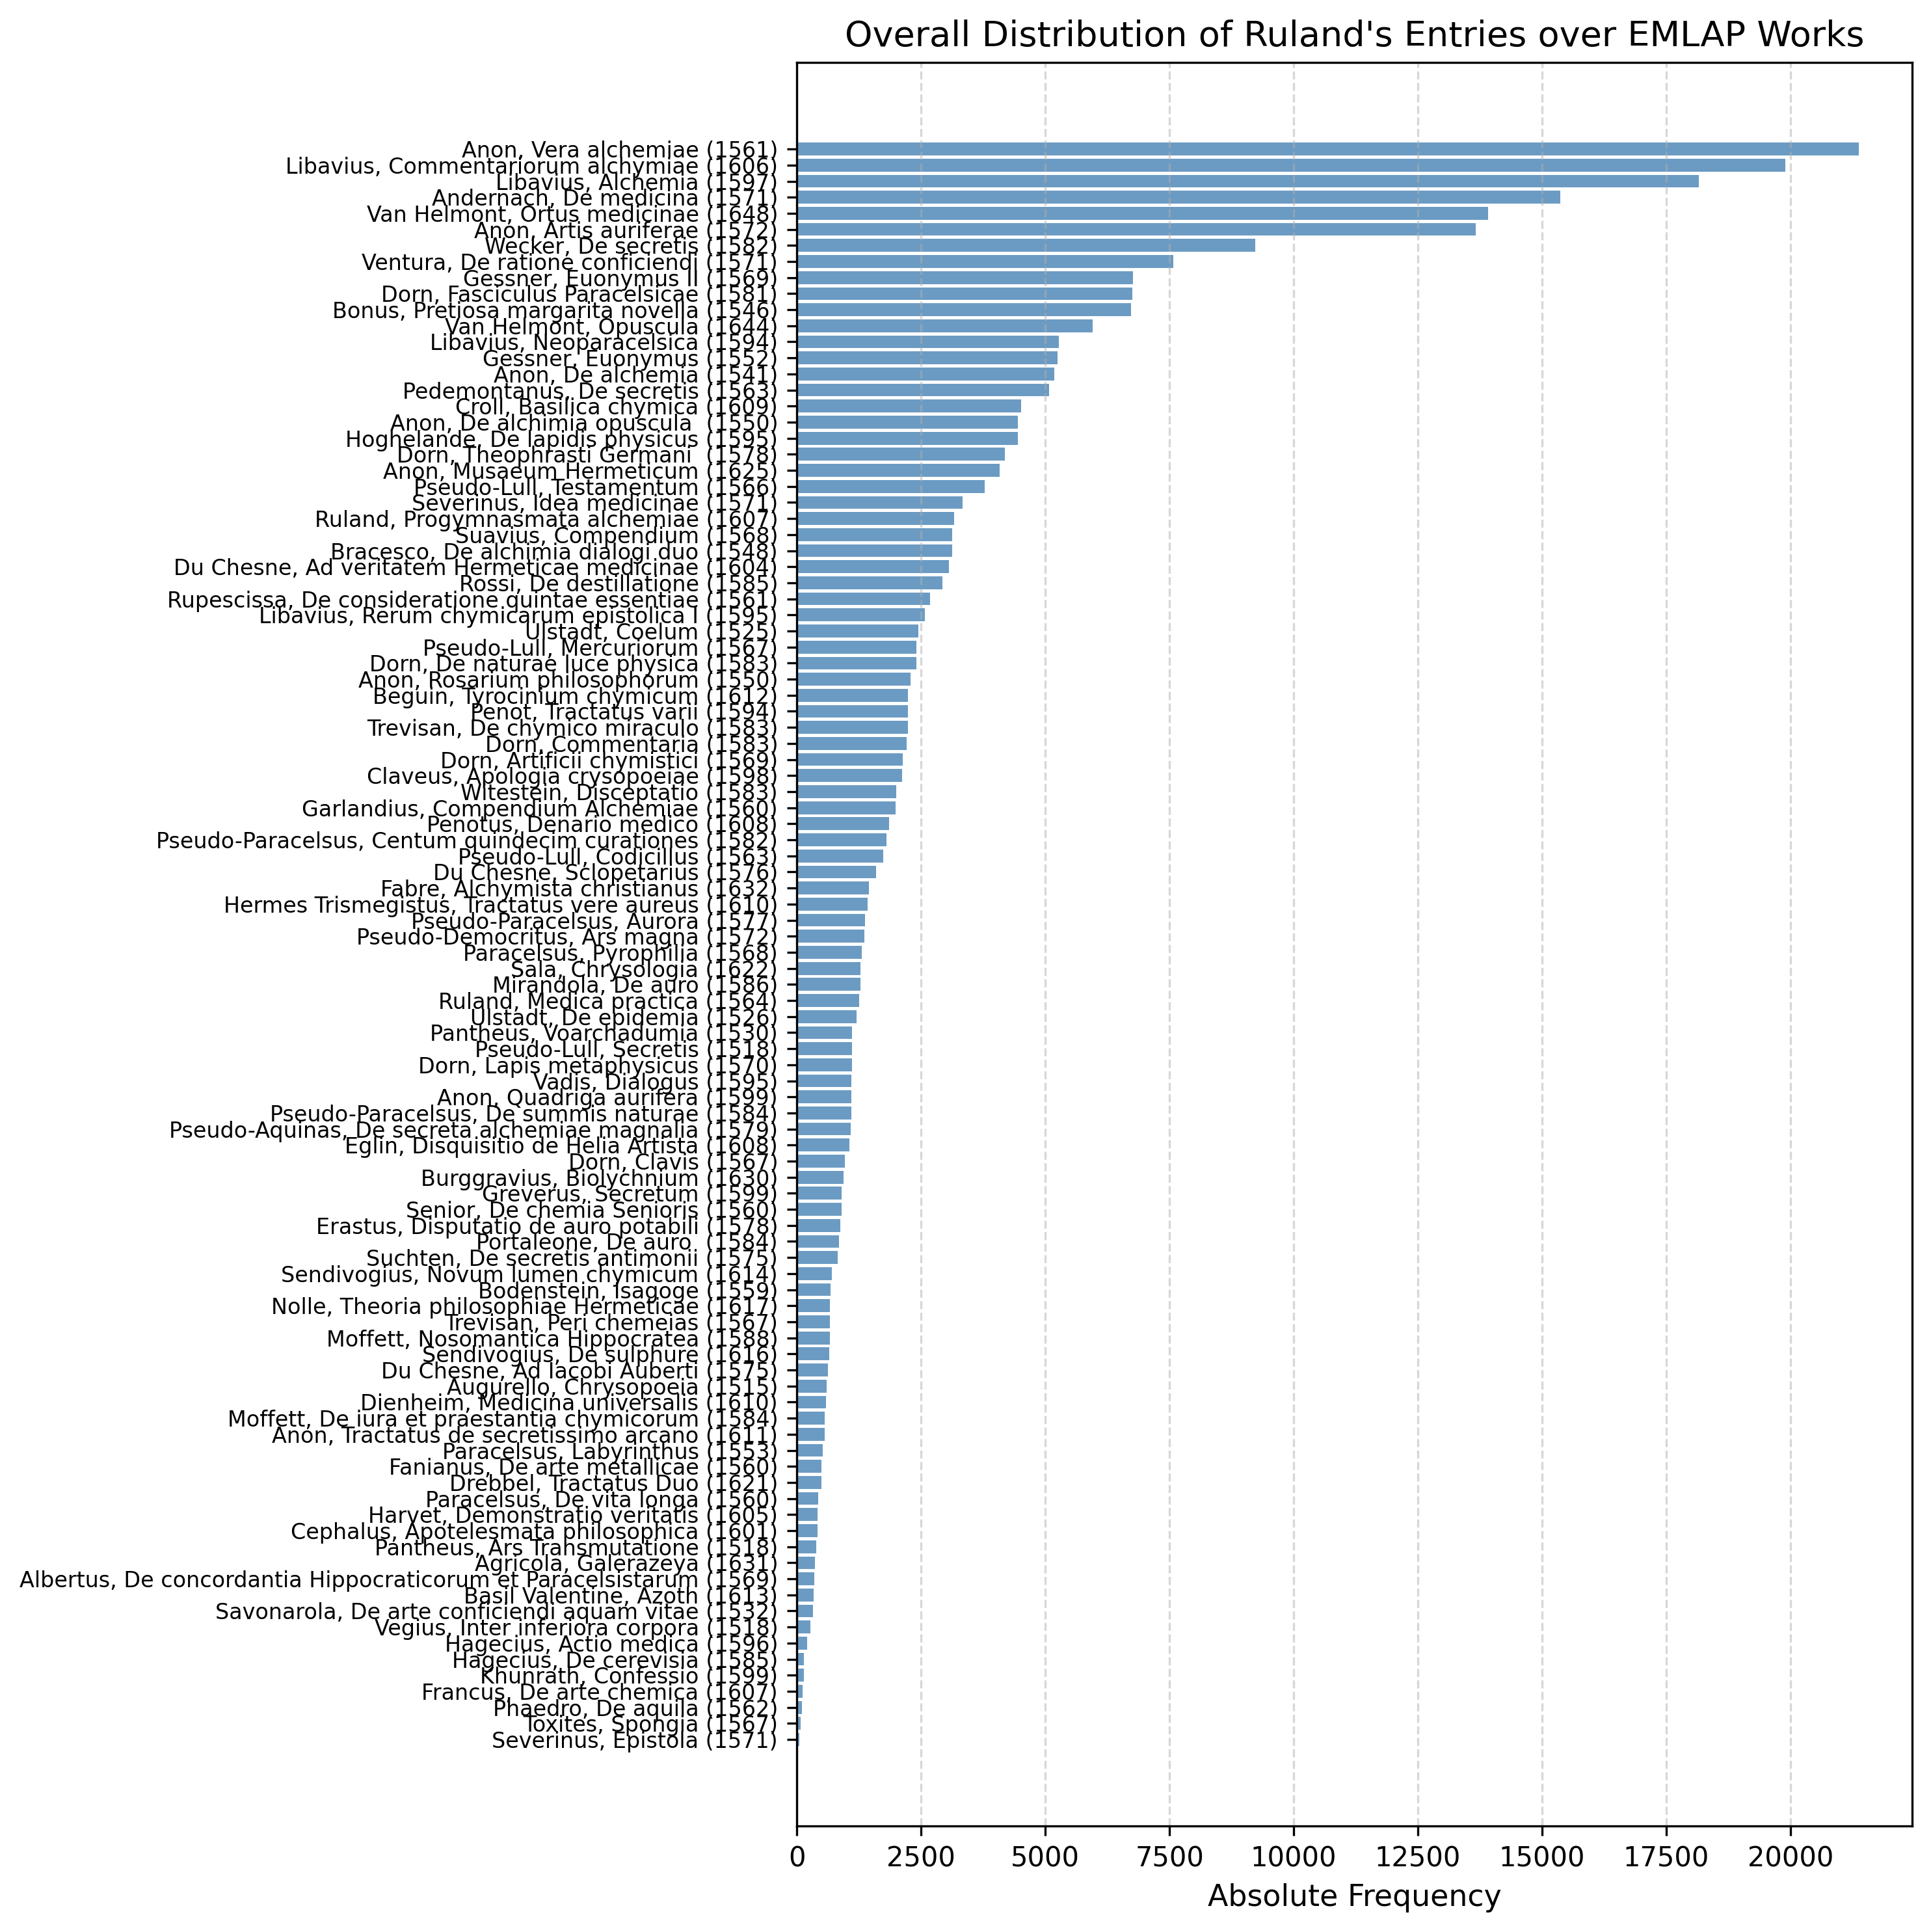

In [161]:
# Sort descending by Frequency
df = df.sort_values("Frequency", ascending=False)

# Prepare labels and positions
x_labels = df["labeldate"].tolist()
y_pos = np.arange(len(x_labels))

# Title
title = "Overall Distribution of Ruland's Entries over EMLAP Works"

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=300, tight_layout=True)

# Horizontal bar plot (sorted)
ax.barh(y_pos, df["Frequency"].to_numpy(), color="steelblue", alpha=0.8)

# Labeling
ax.set_yticks(y_pos)
ax.set_yticklabels(x_labels, fontsize=8)
ax.invert_yaxis()  # Highest at the top
ax.set_xlabel("Absolute Frequency", fontsize=11)
ax.set_title(title, fontsize=13)

# Add gridlines for readability
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [162]:
fig.savefig("../figures/ruland-emlap-overall-distribution-absolute.png", dpi=300)

In [163]:
df[-5:]["tokens_N"]

51    5358
98    4512
30    2489
13    2646
7     2261
Name: tokens_N, dtype: int64

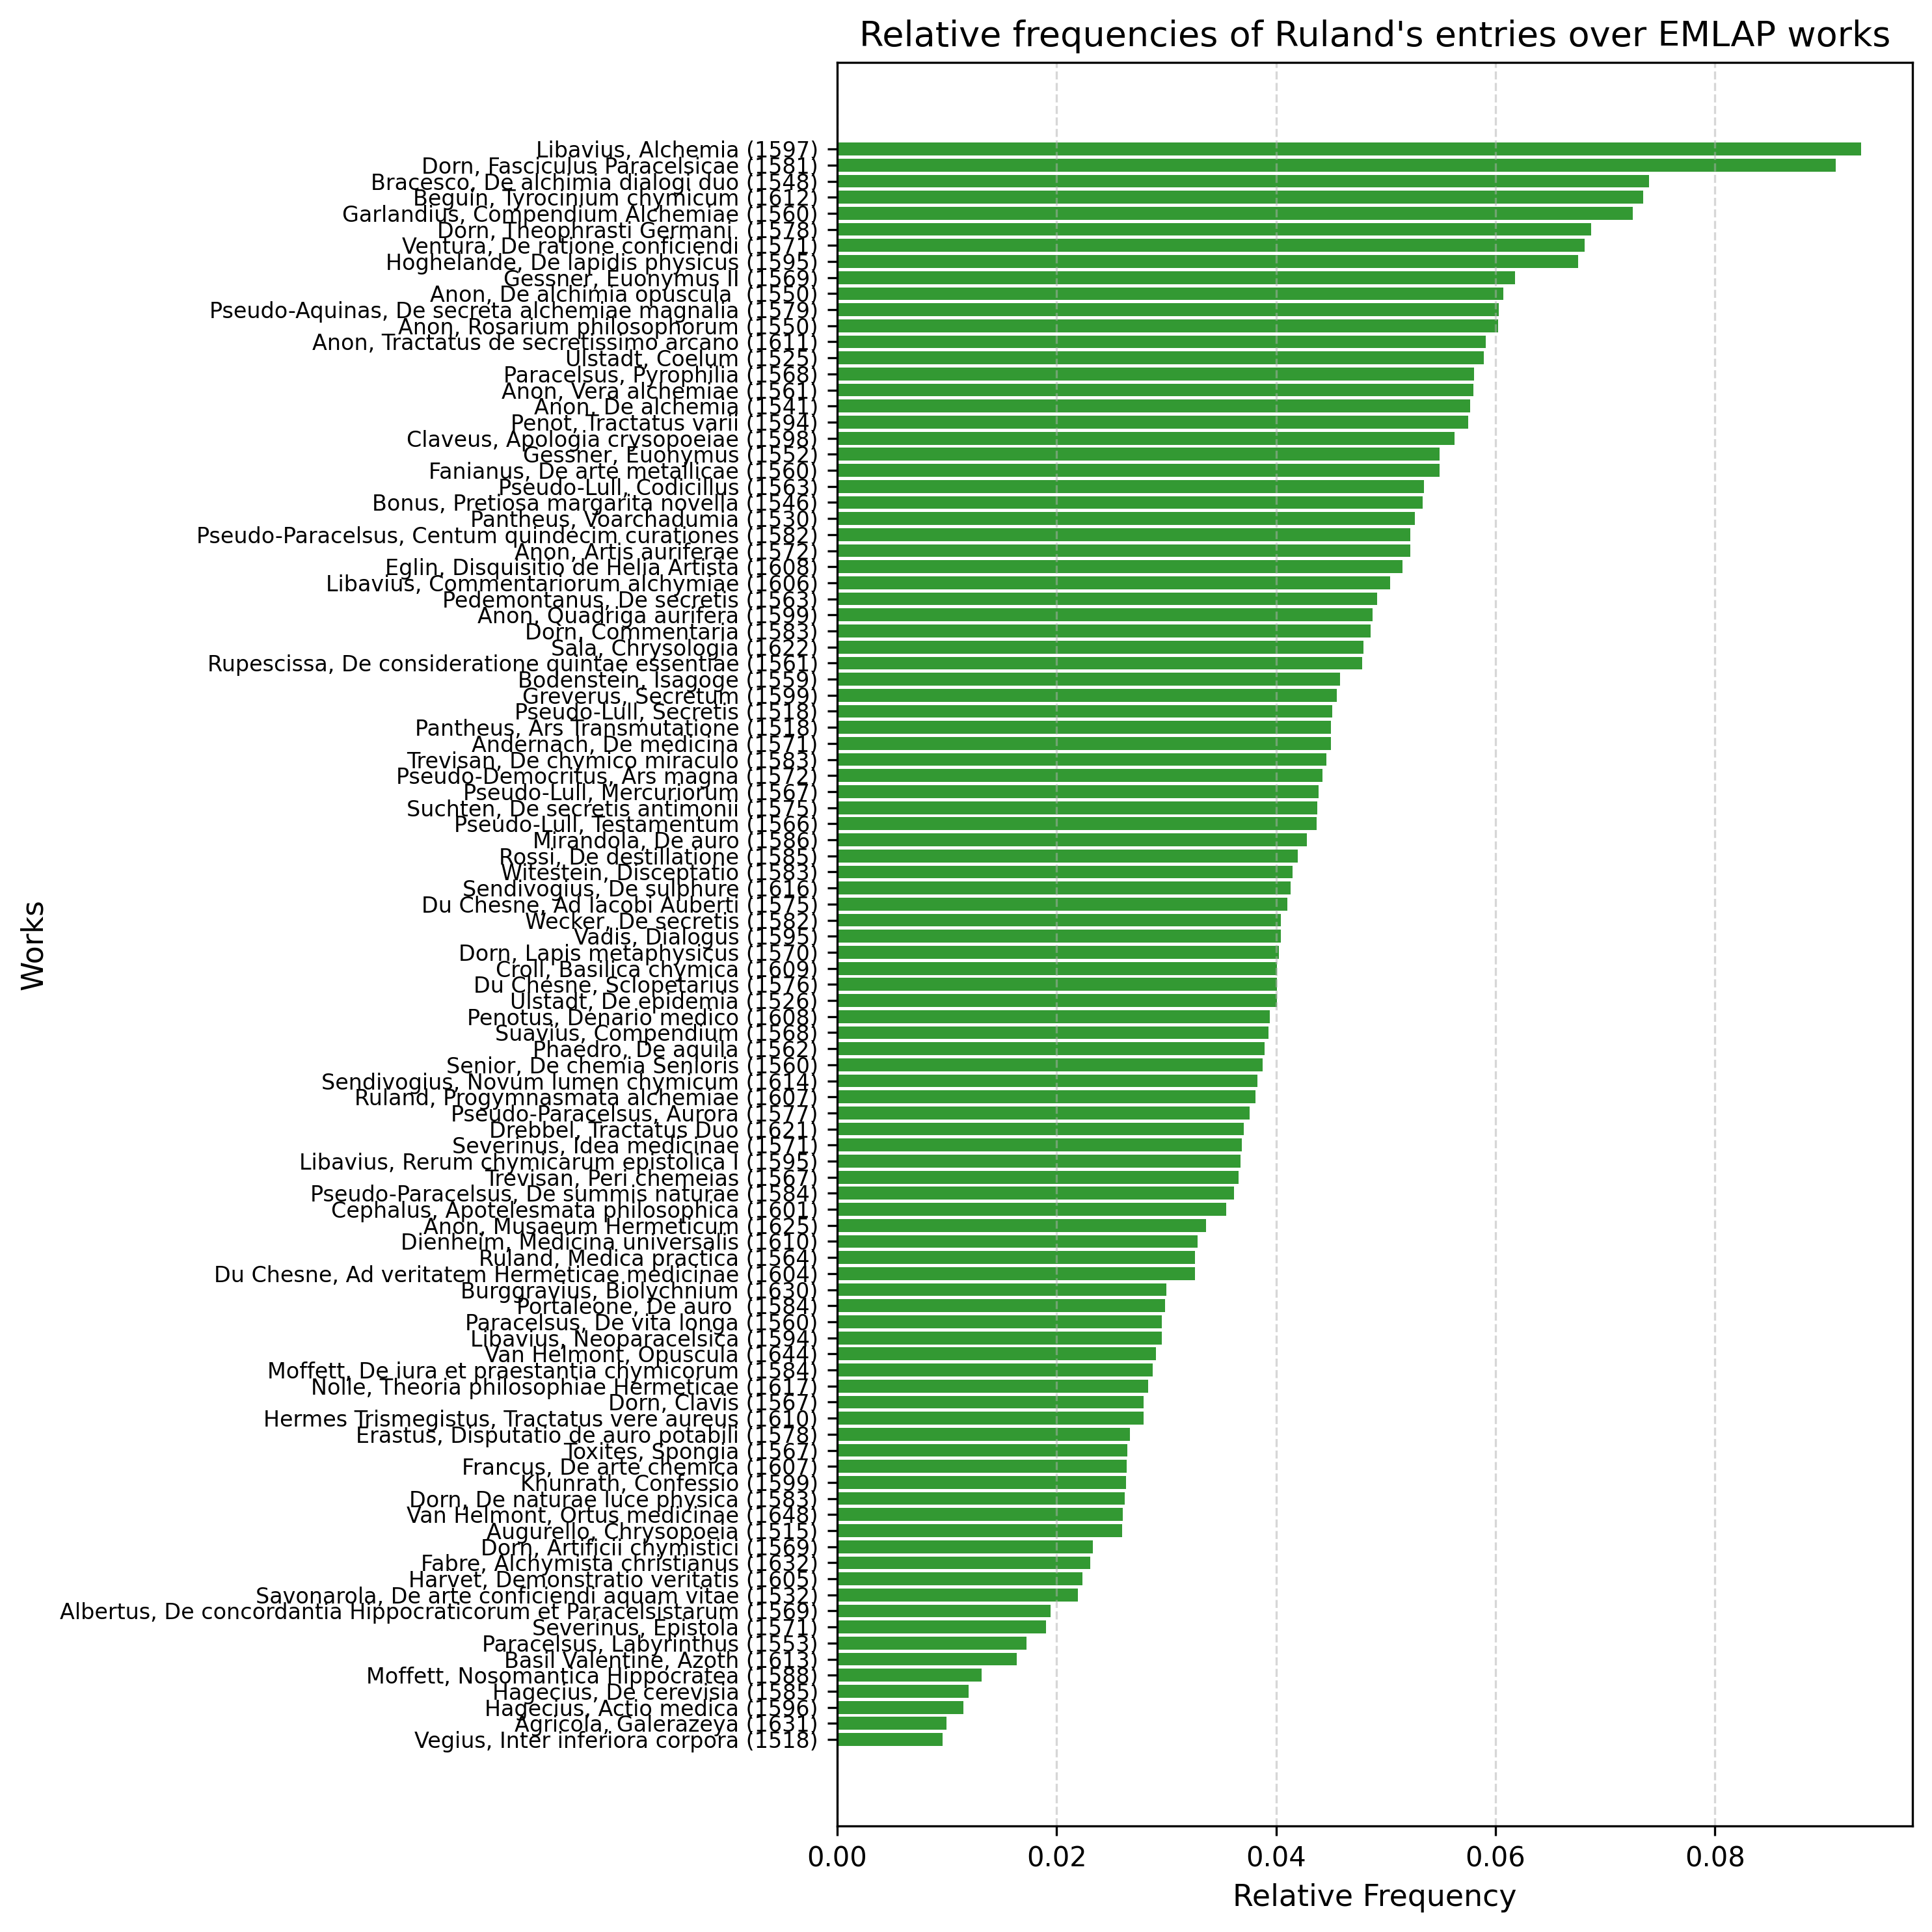

In [164]:
title = "Relative frequencies of Ruland's entries over EMLAP works"
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

df = df.sort_values("RelativeFrequency", ascending=False)

x_labels = df["labeldate"].tolist()
y_pos


# Horizontal bar plot (sorted)
ax.barh(y_pos, df["RelativeFrequency"].to_numpy(), color="green", alpha=0.8)

# Labeling
ax.set_yticks(y_pos)
ax.set_ylabel("Works", fontsize=11)
ax.set_yticklabels(x_labels, fontsize=8)
ax.invert_yaxis()  # Highest at the top
ax.set_xlabel("Relative Frequency", fontsize=11)
ax.set_title(title, fontsize=13)

# Add gridlines for readability
ax.grid(axis="x", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()

In [165]:
fig.savefig("../figures/ruland-emlap-overall-distribution-relative.png", dpi=300)

In [137]:
emlap_metadata["no."] = emlap_metadata["no."].astype(str)

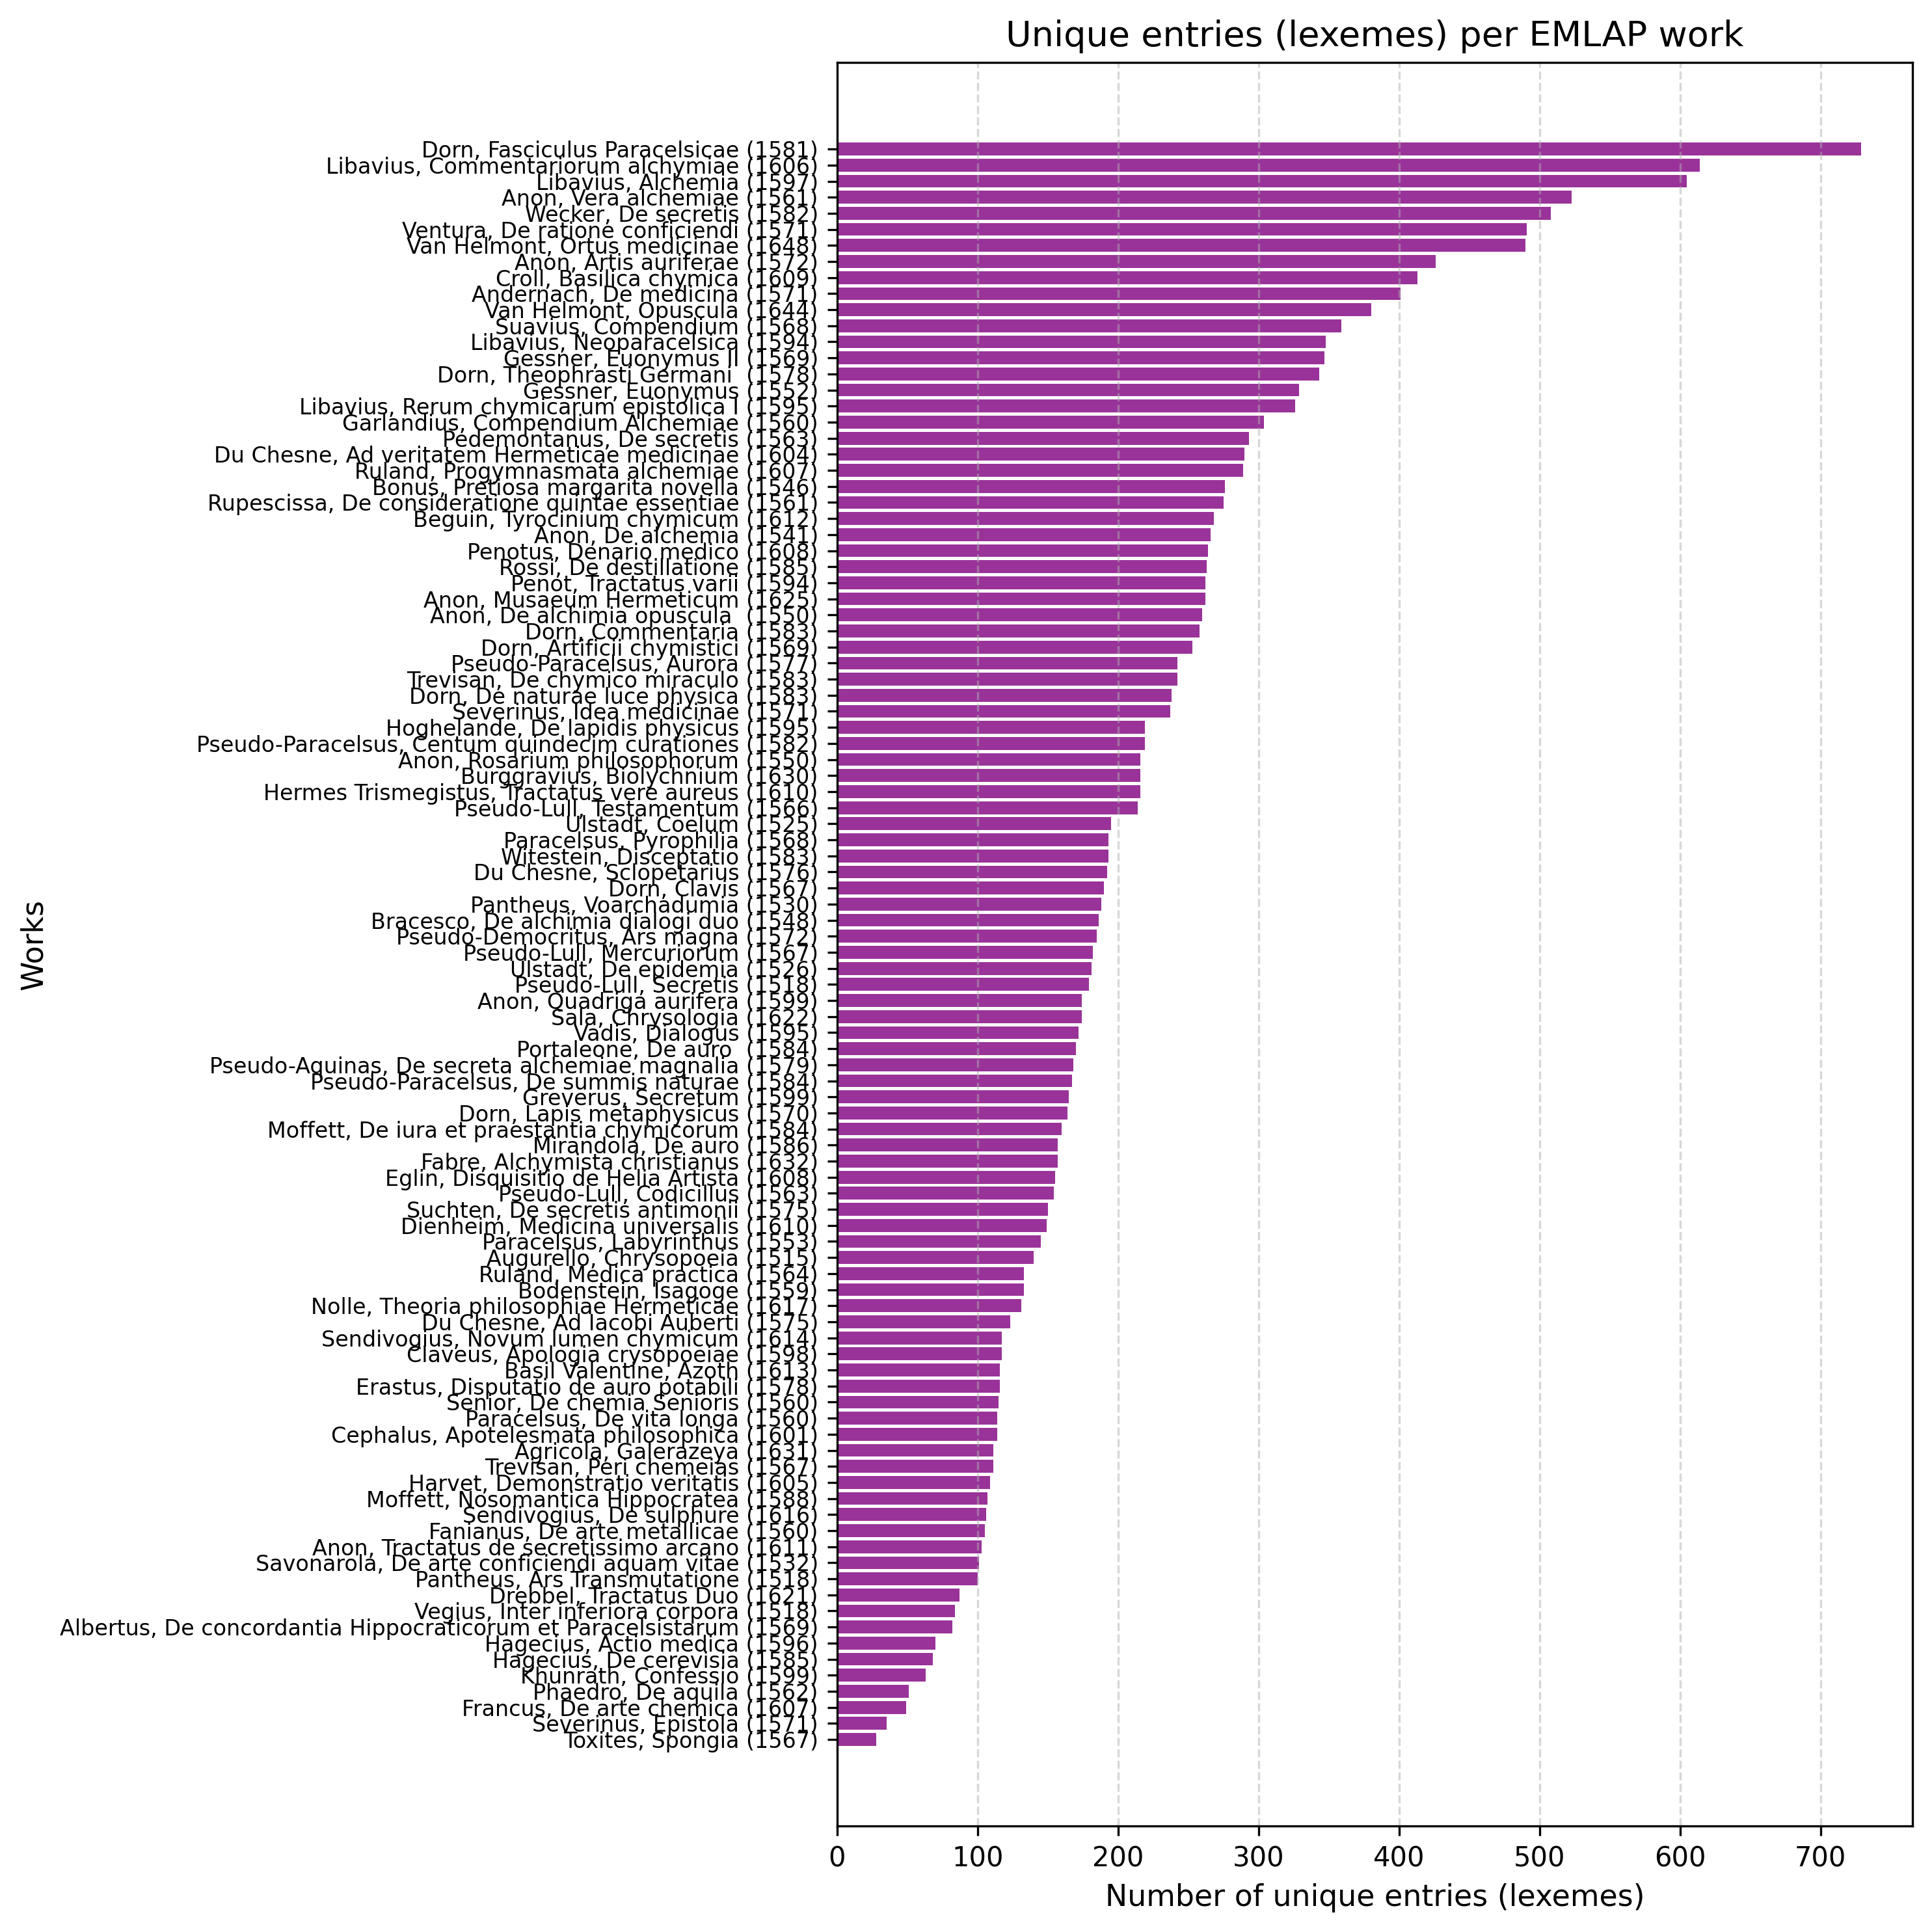

In [138]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) work_id → set of lexemes
work_to_lexemes = defaultdict(set)

# 2) Fill mapping from lexeme_df
for _, row in lexeme_df.iterrows():
    lemma = row["Lemma"]
    for work_id in row["instances_ids"]:
        work_to_lexemes[str(work_id)].add(lemma)

# 3) Counts DF
work_entry_counts = pd.DataFrame(
    [{"no.": w, "unique_entries": len(lemmas)} for w, lemmas in work_to_lexemes.items()]
)

# 4) Merge with metadata
work_entry_counts = emlap_metadata.merge(work_entry_counts, on="no.", how="left")
work_entry_counts["unique_entries"] = work_entry_counts["unique_entries"].fillna(0).astype(int)

# 5) Sort like your barh example (by value descending)
work_entry_counts = work_entry_counts.sort_values("unique_entries", ascending=False)

# 6) Plot barh
title = "Unique entries (lexemes) per EMLAP work"
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

y_pos = np.arange(len(work_entry_counts))
x_labels = work_entry_counts["labeldate"].tolist()

ax.barh(y_pos, work_entry_counts["unique_entries"].to_numpy(), color="purple", alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(x_labels, fontsize=8)
ax.invert_yaxis()  # biggest on top

ax.set_xlabel("Number of unique entries (lexemes)", fontsize=11)
ax.set_ylabel("Works", fontsize=11)
ax.set_title(title, fontsize=13)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

In [139]:
fig.savefig("../figures/ruland-emlap-unique-entries.png", dpi=300)

In [142]:
df.head()

grela_id  vocab_size
0  emlap_100001        4183
1  emlap_100002        3292
2  emlap_100003        1773
3  emlap_100004       13188
4  emlap_100005        3788

In [144]:
# get vocab size per EMLAP work
query = """
SELECT
  t.grela_id,
  COUNT(DISTINCT t.lemma) AS vocab_size
FROM tokens t
JOIN works w
  ON w.grela_id = t.grela_id
WHERE w.grela_source = 'emlap'
  AND t.lemma IS NOT NULL
  AND trim(t.lemma) <> ''
GROUP BY t.grela_id
ORDER BY t.grela_id
"""

resp = requests.post(api_url, json={"query": query}, timeout=120)
resp.raise_for_status()

download_url = resp.json()["download_url"]
df = pd.read_parquet(download_url)

# dict: {grela_id: vocab_size}
vocab_by_work = dict(zip(df["grela_id"], df["vocab_size"]))

print(len(vocab_by_work))
print(list(vocab_by_work.items())[:5])

100
[('emlap_100001', 4183), ('emlap_100002', 3292), ('emlap_100003', 1773), ('emlap_100004', 13188), ('emlap_100005', 3788)]


In [166]:
# add vocab size to work_entry_counts DF
work_entry_counts["vocab_size"] = work_entry_counts["no."].apply(lambda x: vocab_by_work["emlap_" + str(x)])

In [167]:
# check correlation between "tokens_N" and "vocab_size"
work_entry_counts[["tokens_N", "vocab_size"]].corr()

tokens_N  vocab_size
tokens_N    1.000000    0.932232
vocab_size  0.932232    1.000000

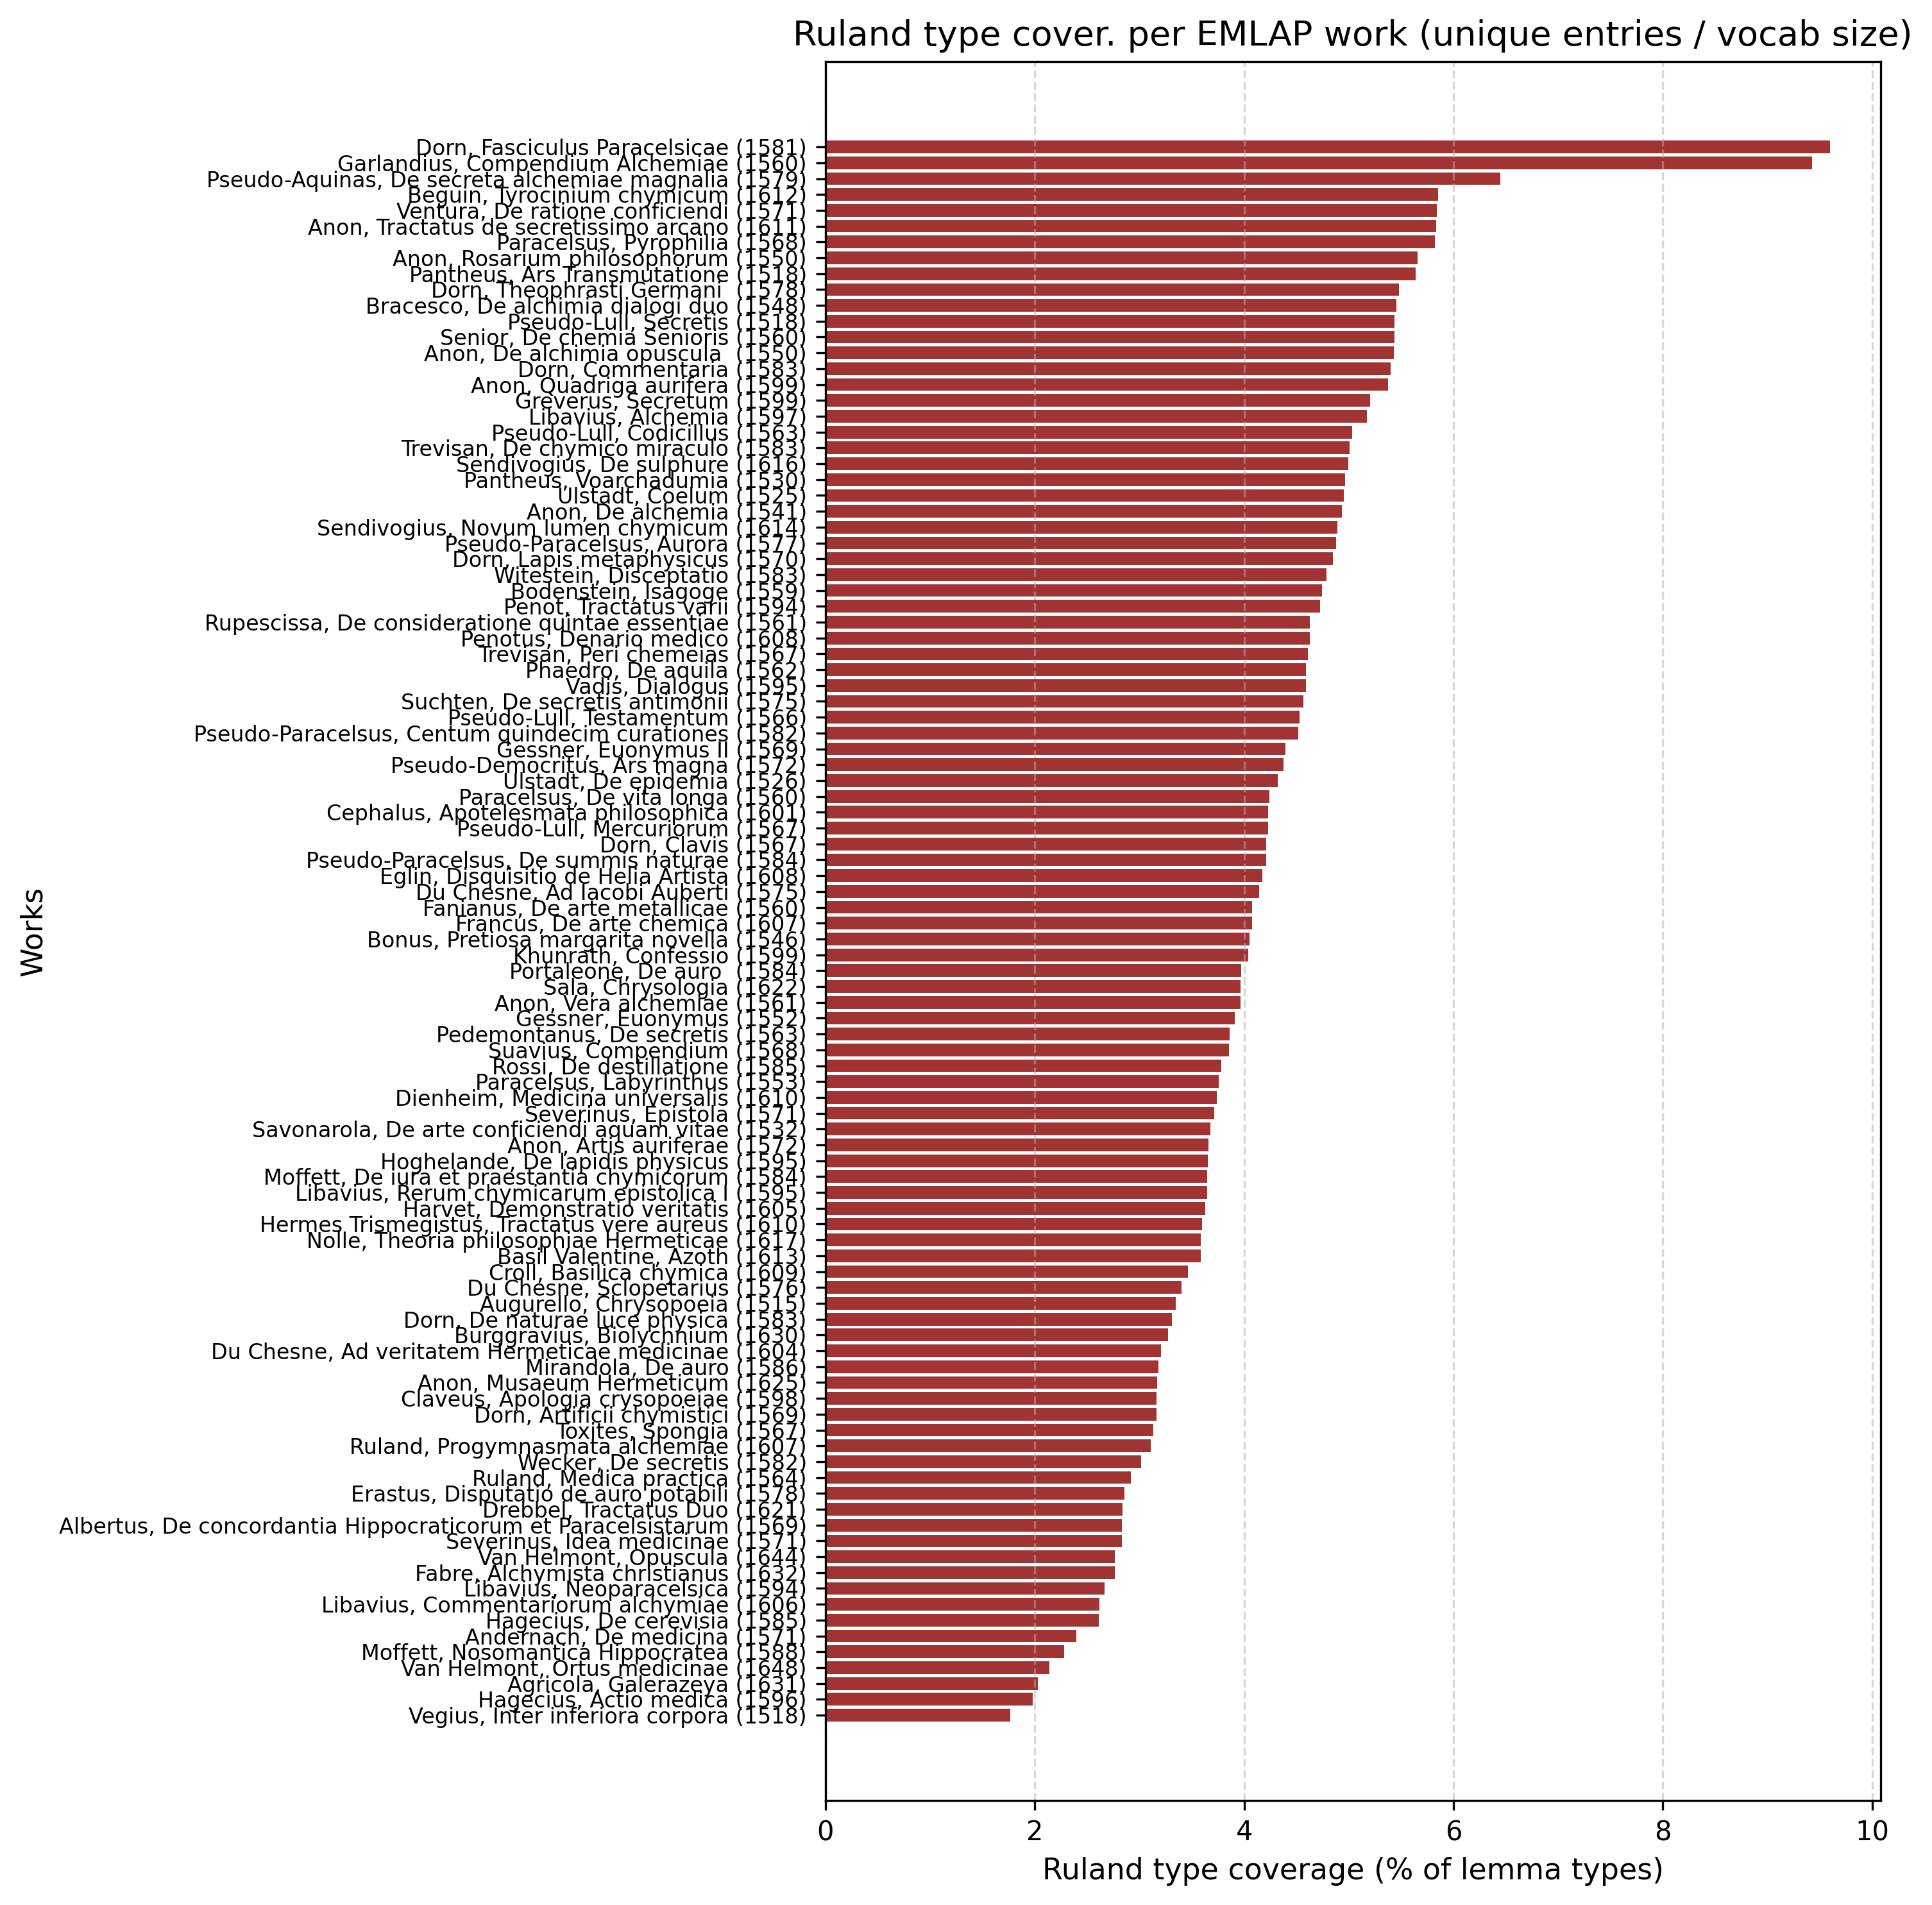

In [168]:
# 5) Compute type-normalized coverage (share of work vocab covered by Ruland entries)
work_entry_counts["ruland_type_share"] = np.where(
    work_entry_counts["vocab_size"] > 0,
    work_entry_counts["unique_entries"] / work_entry_counts["vocab_size"],
    0.0
)

# Optional: express as percent for plotting
work_entry_counts["ruland_type_share_pct"] = 100 * work_entry_counts["ruland_type_share"]

# 6) Sort by share descending (like your previous plot)
work_entry_counts = work_entry_counts.sort_values("ruland_type_share_pct", ascending=False)

# 7) Plot barh
title = "Ruland type cover. per EMLAP work (unique entries / vocab size)"
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

y_pos = np.arange(len(work_entry_counts))
y_labels = work_entry_counts["labeldate"].tolist()

ax.barh(
    y_pos,
    work_entry_counts["ruland_type_share_pct"].to_numpy(),
    color="darkred",
    alpha=0.8
)

ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=8)
ax.invert_yaxis()  # biggest on top

ax.set_xlabel("Ruland type coverage (% of lemma types)", fontsize=11)
ax.set_ylabel("Works", fontsize=11)
ax.set_title(title, fontsize=13)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

In [169]:
fig.savefig("../figures/ruland-emlap-unique-entries-vocab-share.png", dpi=300)